# Random Forest Rangers - Predicting Car Sales Prices
## Preprocessing

In [19]:
# Install dependencies
# !pip install -q -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [2]:
dataset_original_train = pd.read_csv('data/Original/train.csv')
dataset_original_test = pd.read_csv('data/Original/test.csv')

dataset_generated = pd.read_csv('./data/Generated/full_used_car_prices_generated.csv')
print(dataset_original_train.dtypes)

brand           object
model           object
model_year       int64
milage          object
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object


### Ensure consistent data formatting

In [3]:

    


# Function to reformat numeric attributes with non-numeric elements such as currency symbols
def reformat_non_numeric(text):
    if isinstance(text, (float, int)):
        return text
    return float(re.sub(r'[^\d.]', '', text))

# Function to reformat the clean title column
def reformat_clean_title(text):
    return 1 if text == 'Yes' else 0

# Function to reformat the accident column
def reformat_accident(text):
    return 0 if text == '' or text == 'None reported' else 1

def app_reformat(dataset):
    # Reformat the existing columns
    dataset['clean_title'] = dataset['clean_title'].apply(reformat_clean_title)
    dataset['price'] = dataset['price'].apply(reformat_non_numeric)
    dataset['milage'] = dataset['milage'].apply(reformat_non_numeric)
    dataset['accident'] = dataset['accident'].apply(reformat_accident)

    return dataset

dataset_original_train = app_reformat(dataset_original_train)
dataset_original_test = app_reformat(dataset_original_test)
dataset_generated = app_reformat(dataset_generated)
    

dataset = dataset_original_train.copy()
dataset.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Nissan,Maxima GLE,2000,194277.0,Gasoline,222.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Beige,1,1,2300
1,Mercedes-Benz,S-Class S 550 4MATIC,2015,13300.0,Gasoline,449.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,0,1,62500
2,GMC,Acadia SLE,2020,30426.0,Gasoline,2.5L I4 16V GDI DOHC,9-Speed Automatic,Ebony Twilight Metallic,Jet Black,1,0,29645
3,Ford,Expedition Max XLT,2020,67072.0,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Purple,Black,0,1,38500
4,Jeep,Compass Sport,2016,99000.0,Gasoline,172.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Gray,1,1,5000


### Extract additional features

In [4]:
dataset = dataset.copy()

# Function to extract number of cylinders
def extract_cylinders(text):
    '''
    Function to extract the number of cylinders from the text
    --------------------------------
    Parameters:
        text (str): The text to extract the number of cylinders from
    --------------------------------
    Returns:
        int: The number of cylinders in the text
    '''
    match = re.search(r'(\d+)\s*Cylinder', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract horsepower
def extract_hp(text):
    '''
    Function to extract the horsepower from the text
    --------------------------------
    Parameters:
        text (str): The text to extract the horsepower from
    --------------------------------
    Returns:
        float: The horsepower in the text
    '''
    match = re.search(r'(\d+(?:\.\d+)?)\s*HP', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract cubic capacity
def extract_capacity(text):
    '''
    Function to extract the cubic capacity from the text
    --------------------------------
    Parameters:
        text (str): The text to extract the cubic capacity from
    --------------------------------
    Returns:
        float: The cubic capacity in the text
    '''
    match = re.search(r'(\d+(?:\.\d+)?)\s*L', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract whether the car has a turbo
def extract_turbo(text):
    '''
    Function to extract whether the car has a turbo
    --------------------------------
    Parameters:
        text (str): The text to extract the turbo information from
    --------------------------------
    Returns:
        int: 1 if the text contains turbo, 0 otherwise
    '''
    match = re.search(r'Turbo', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract gear type
def extract_gear_type(text):
    '''
    Function to extract the gear type from the text
    --------------------------------
    Parameters:
        text (str): The text to extract the gear type from
    --------------------------------
    Returns:
        int: 1 if the text contains automatic, 0 if it contains manual, None otherwise
    '''
    match_automatic = re.search(r'Automatic|A/T', text, re.IGNORECASE)
    match_manual = re.search(r'Manual|M/T', text, re.IGNORECASE)
    return 1 if match_automatic else 0 if match_manual else None

# Function to extract the number of gears
def extract_gears(text):
    '''
    Function to extract the number of gears from the text
    --------------------------------
    Parameters:
        text (str): The text to extract the number of gears from
    --------------------------------
    Returns:
        int: The number of gears in the text
    '''
    match = re.search(r'(\d+)-Speed\b', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract whether the car has dual shift
def extract_dual_shift(text):
    '''
    Function to extract whether the car has dual shift
    --------------------------------
    Parameters:
        text (str): The text to extract the dual shift information from
    --------------------------------
    Returns:
        int: 1 if the text contains dual shift, 0 otherwise
    '''
    match = re.search(r'Dual Shift', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract whether the car has a monochrome color
monochrome = ['Black', 'White', 'Silver', 'Gray']
def extract_monochrome_color(text):
    '''
    Function to extract whether the car has a monochrome color
    --------------------------------
    Parameters:
        text (str): The text to extract the monochrome color from
    --------------------------------
    Returns:
        int: 1 if the car has a monochrome color, 0 otherwise
    '''
    for color in monochrome:
        match = re.search(color, text, re.IGNORECASE)
        if match:
            return 1
    return 0

# Function to check if interior and exterior colors match
def extract_color_match(row):
    '''
    Function to check if interior and exterior colors match
    --------------------------------
    Parameters:
        row (Series): The row of the dataset to check if the colors match
    --------------------------------
    Returns:
        int: 1 if the colors match, 0 otherwise
    '''
    return 1 if row['ext_col'].lower() == row['int_col'].lower() else 0

# Function to extract if the car is a hybrid
def extract_hybrid(text):
    '''
    Function to extract if the car is a hybrid
    --------------------------------
    Parameters:
        text (str): The text to extract the hybrid information from
    --------------------------------
    Returns:
        int: 1 if the text contains hybrid, 0 otherwise
    '''   
    match = re.search(r'Hybrid', text, re.IGNORECASE)
    return 1 if match else 0
 
# Function to extract if the car is diesel
def extract_diesel(text):
    '''
    Function to extract if the car is diesel
    --------------------------------
    Parameters:
        text (str): The text to extract the diesel information from
    --------------------------------
    Returns:
        int: 1 if the text contains diesel, 0 otherwise    
    '''
    match = re.search(r'Diesel', text, re.IGNORECASE)
    return 1 if match else 0
    
# Function to extract if the car is gasolin
def extract_gasoline(text):
    '''
    Function to extract if the car is gasoline
    --------------------------------
    Parameters:
        text (str): The text to extract the gasoline information from
    --------------------------------
    Returns:
        int: 1 if the text contains gasoline, 0 otherwise
    '''
    match = re.search(r'Gasoline', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract mileage per year
def extract_mileage_per_year(row):
    '''
    Function to extract the mileage per year of the vehicle
    --------------------------------
    Parameters:
        row (Series): The row of the dataset to extract the mileage per year from
    --------------------------------
    Returns:
        float: The mileage per year of the vehicle
    '''
    vehicle_age = 2024 - row['model_year']
    return row['milage'] / max(vehicle_age, 1)

# Apply the extraction functions to create new columns
def app_extract(dataset):
    '''
    Extracts features from the engine, transmission, exterior color, interior color, and fuel type columns
    --------------------------------
    Parameters:
        dataset (DataFrame): The dataset to extract features from
    --------------------------------
    Returns:
        DataFrame: The dataset with the extracted features
    '''
    dataset['cylinders'] = dataset['engine'].astype(str).apply(extract_cylinders)
    dataset['horsepower'] = dataset['engine'].astype(str).apply(extract_hp)
    dataset['cubic_capacity'] = dataset['engine'].astype(str).apply(extract_capacity)
    dataset['turbo'] = dataset['engine'].astype(str).apply(extract_turbo)
    dataset['is_automatic'] = dataset['transmission'].astype(str).apply(extract_gear_type)
    dataset['gears'] = dataset['transmission'].astype(str).apply(extract_gears)
    dataset['dual_shift'] = dataset['transmission'].astype(str).apply(extract_dual_shift)
    dataset['ext_col_mon'] = dataset['ext_col'].astype(str).apply(extract_monochrome_color)
    dataset['int_col_mon'] = dataset['int_col'].astype(str).apply(extract_monochrome_color)
    dataset['color_match'] = dataset.apply(lambda row: extract_color_match(row), axis=1)
    dataset['is_hybrid'] = dataset['fuel_type'].astype(str).apply(extract_hybrid)
    dataset['is_diesel'] = dataset['fuel_type'].astype(str).apply(extract_diesel)
    dataset['is_gasoline'] = dataset['fuel_type'].astype(str).apply(extract_gasoline)
    #dataset['mileage_per_year'] = dataset.apply(lambda row: extract_mileage_per_year(row), axis=1)

    return dataset


dataset_original_train = app_extract(dataset_original_train)
dataset_original_test = app_extract(dataset_original_test)
dataset_generated = app_extract(dataset_generated)

dataset = dataset_original_train.copy()
dataset.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,turbo,is_automatic,gears,dual_shift,ext_col_mon,int_col_mon,color_match,is_hybrid,is_diesel,is_gasoline
0,Nissan,Maxima GLE,2000,194277.0,Gasoline,222.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Beige,1,...,0,1.0,NaN,0,0,0,0,0,0,1
1,Mercedes-Benz,S-Class S 550 4MATIC,2015,13300.0,Gasoline,449.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,0,...,0,1.0,NaN,0,1,1,1,0,0,1
2,GMC,Acadia SLE,2020,30426.0,Gasoline,2.5L I4 16V GDI DOHC,9-Speed Automatic,Ebony Twilight Metallic,Jet Black,1,...,0,1.0,9.0,0,0,1,0,0,0,1
3,Ford,Expedition Max XLT,2020,67072.0,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Purple,Black,0,...,0,1.0,NaN,0,0,1,0,0,0,1
4,Jeep,Compass Sport,2016,99000.0,Gasoline,172.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Gray,1,...,0,1.0,6.0,0,1,1,0,0,0,1


### Encode categorical features

In [5]:
# Dataframe containing the median price of each brand
dataset = dataset_original_train.copy()
brand_median_price = dataset.groupby('brand')['price'].median().reset_index()
brand_median_price.columns = ['brand', 'brand_median_price']

# Show in ascending order
brand_median_price = brand_median_price.sort_values('brand_median_price', ascending=True)
# Reset the index
brand_median_price = brand_median_price.reset_index(drop=True)

# Show cummulative sum of the number of brand entries in the dataset
for i in range(1, len(brand_median_price)):
    brand_median_price['cum_entries'] = brand_median_price['brand'].apply(lambda x: dataset[dataset['brand'] == x].shape[0]).cumsum()

# Show relative cummulative sum of the number of brand entries in the dataset
brand_median_price['rel_cum_entries'] = brand_median_price['cum_entries'] / dataset.shape[0]
brand_median_price['rel_cum_entries'] = brand_median_price['rel_cum_entries'] * 100

pd.set_option('display.max_rows', None)	
brand_median_price.head(100)

,brand,brand_median_price,cum_entries,rel_cum_entries
0,smart,5000.0,1,0.031182
1,Suzuki,6900.0,2,0.062364
2,Scion,9499.0,6,0.187091
3,Saab,10225.0,8,0.249454
4,Mitsubishi,10500.0,25,0.779545
5,Chrysler,10625.0,47,1.465544
6,Saturn,12000.0,51,1.590271
7,Pontiac,12875.0,63,1.964453
8,MINI,13999.0,90,2.806361
9,FIAT,15499.0,94,2.931088


In [6]:
def define_price_groups(dataset):
    '''
    Function to divide the brands into the groups "Low_priced_brands", "Mid_priced_brands" and "High_priced_brands" based on their median price
    --------------------------------
    Parameters:
        dataset (DataFrame): The dataset containing the brands and their prices
    --------------------------------
    Returns:
    '''
    # Divide the brands into the groups "Low_priced_brands", "Mid_priced_brands" and "High_priced_brands" and "Luxury_brands" based on the price median of the brand

    # Low priced brands (if the median price of the brand is less than 20.000
    dataset['Low_priced_brands'] = dataset['price'].apply(lambda x: 1 if x < 20000 else 0)

    # Mid priced brands (if the median price of the brand is between 20.000 and 33.000
    dataset['Mid_priced_brands'] = dataset['price'].apply(lambda x: 1 if x >= 20000 and x < 33000 else 0)

    # High priced brands (if the median price of the brand is between 33.000 and 100.000
    dataset['High_priced_brands'] = dataset['price'].apply(lambda x: 1 if x >= 33000 and x < 100000 else 0)

    # Luxury brands (if the median price of the brand is more than 100.000
    dataset['Luxury_brands'] = dataset['price'].apply(lambda x: 1 if x >= 100000 else 0)

    return dataset


dataset_original_train = define_price_groups(dataset_original_train)
dataset_original_test = define_price_groups(dataset_original_test)
dataset_generated = define_price_groups(dataset_generated)

# Show the first rows of the dataset
dataset_original_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,ext_col_mon,int_col_mon,color_match,is_hybrid,is_diesel,is_gasoline,Low_priced_brands,Mid_priced_brands,High_priced_brands,Luxury_brands
0,Nissan,Maxima GLE,2000,194277.0,Gasoline,222.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Beige,1,...,0,0,0,0,0,1,1,0,0,0
1,Mercedes-Benz,S-Class S 550 4MATIC,2015,13300.0,Gasoline,449.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,0,...,1,1,1,0,0,1,0,0,1,0
2,GMC,Acadia SLE,2020,30426.0,Gasoline,2.5L I4 16V GDI DOHC,9-Speed Automatic,Ebony Twilight Metallic,Jet Black,1,...,0,1,0,0,0,1,0,1,0,0
3,Ford,Expedition Max XLT,2020,67072.0,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Purple,Black,0,...,0,1,0,0,0,1,0,0,1,0
4,Jeep,Compass Sport,2016,99000.0,Gasoline,172.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Gray,1,...,1,1,0,0,0,1,1,0,0,0


### Compute pairwise correlations

<Axes: >

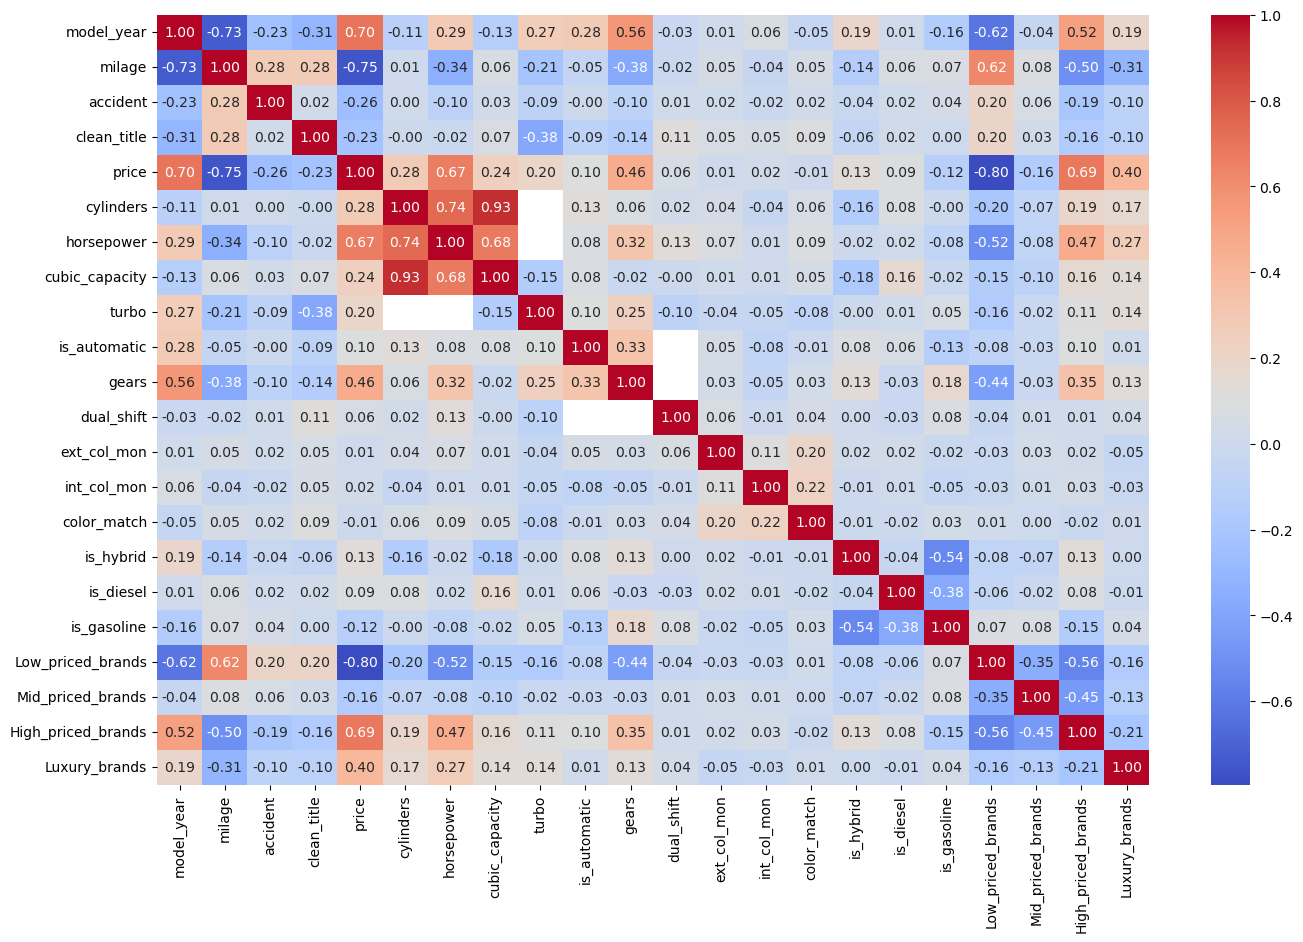

In [7]:
# Select only numeric columns
non_numeric_columns = dataset_original_train.select_dtypes(exclude=[np.number]).columns

# Drop non-numeric columns
dataset = dataset_original_train.copy().drop(columns=non_numeric_columns)

# Calculate the Spearman correlation matrix
spearman_corr = dataset.corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm')

High correlations between:
- `Model Year` and `Mileage`
- `Cylinders`, `Cubic Capacity` and `Horsepower`

In [8]:
# Sum of NaN values for each column
for col in dataset_original_train.columns:
    print(col, dataset_original_train[col].isnull().sum())

brand 0
model 0
model_year 0
milage 0
fuel_type 135
engine 0
transmission 0
ext_col 0
int_col 0
accident 0
clean_title 0
price 0
cylinders 740
horsepower 634
cubic_capacity 172
turbo 0
is_automatic 392
gears 1500
dual_shift 0
ext_col_mon 0
int_col_mon 0
color_match 0
is_hybrid 0
is_diesel 0
is_gasoline 0
Low_priced_brands 0
Mid_priced_brands 0
High_priced_brands 0
Luxury_brands 0


There are many rows with missing values. Especially the "gears", "Horsepower" and "cylinder" columns have over 600 missing values each. Because of 'gears' over 60% of the rows have missing values.

In [9]:
# Show rows with NaN values
dataset = dataset_original_train.copy()
# Drop gears
dataset = dataset.drop(columns=['gears'])
dataset = dataset.drop(columns=['cylinders'])
# dataset = dataset.drop(columns=['horsepower'])
# Show rows with NaN values
len(dataset[dataset.isnull().any(axis=1)])/len(dataset)

0.34923604614904896

In [10]:
# Make a new column which states 0, 1 if the "horsepower" column is NaN
dataset['horsepower_nan'] = dataset['horsepower'].isnull().astype(int)
dataset['car_age'] = 2025 - dataset['model_year']
dataset['mileage_per_year'] = dataset['milage'] / dataset['car_age']

dataset.drop(columns=['model_year'], inplace=True)

In [11]:
dataset_2 = dataset.copy()
# integer
dataset_2.head()

,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,...,is_hybrid,is_diesel,is_gasoline,Low_priced_brands,Mid_priced_brands,High_priced_brands,Luxury_brands,horsepower_nan,car_age,mileage_per_year
0,Nissan,Maxima GLE,194277.0,Gasoline,222.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Beige,1,1,...,0,0,1,1,0,0,0,0,25,7771.08
1,Mercedes-Benz,S-Class S 550 4MATIC,13300.0,Gasoline,449.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,0,1,...,0,0,1,0,0,1,0,0,10,1330.00
2,GMC,Acadia SLE,30426.0,Gasoline,2.5L I4 16V GDI DOHC,9-Speed Automatic,Ebony Twilight Metallic,Jet Black,1,0,...,0,0,1,0,1,0,0,1,5,6085.20
3,Ford,Expedition Max XLT,67072.0,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Purple,Black,0,1,...,0,0,1,0,0,1,0,0,5,13414.40
4,Jeep,Compass Sport,99000.0,Gasoline,172.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Gray,1,1,...,0,0,1,1,0,0,0,0,9,11000.00


In [127]:
dataset_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207 entries, 0 to 3206
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brand               3207 non-null   object 
 1   model               3207 non-null   object 
 2   milage              3207 non-null   float64
 3   fuel_type           3072 non-null   object 
 4   engine              3207 non-null   object 
 5   transmission        3207 non-null   object 
 6   ext_col             3207 non-null   object 
 7   int_col             3207 non-null   object 
 8   accident            3207 non-null   int64  
 9   clean_title         3207 non-null   int64  
 10  price               3207 non-null   int64  
 11  horsepower          2573 non-null   float64
 12  cubic_capacity      3035 non-null   float64
 13  turbo               3207 non-null   int64  
 14  is_automatic        2815 non-null   float64
 15  dual_shift          3207 non-null   int64  
 16  ext_co

In [135]:
len(dataset_2[dataset_2["accident"] == 1])

884

In [16]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import patsy

# Function for the model
y, X = patsy.dmatrices('price ~ car_age*mileage_per_year+ accident + Low_priced_brands', dataset_2[(dataset_2['brand']=="Ford")|(dataset_2[dataset_2['brand']=="BMW"])], return_type='dataframe')

# Create the model
model = sm.OLS(y, X)
result = model.fit()

# Show the summary
result.summary()


ModuleNotFoundError: No module named 'statsmodels'

### Handle highly correlated features

Correlation between `cubic_capacity`, `horsepower` and `cylinders`.

In [220]:
# Calculate the number of rows with available values for horsepower, cubic_capacity, and cylinders
available_horsepower = dataset['horsepower'].notnull()
available_cubic_capacity = dataset['cubic_capacity'].notnull()
available_cylinders = dataset['cylinders'].notnull()

# Calculate the number of rows with available values
all_available = available_horsepower & available_cubic_capacity & available_cylinders
two_available = (available_horsepower & available_cubic_capacity & ~available_cylinders) | \
                (available_horsepower & ~available_cubic_capacity & available_cylinders) | \
                (~available_horsepower & available_cubic_capacity & available_cylinders)
one_available = (available_horsepower & ~available_cubic_capacity & ~available_cylinders) | \
                        (~available_horsepower & available_cubic_capacity & ~available_cylinders) | \
                        (~available_horsepower & ~available_cubic_capacity & available_cylinders)
none_available = ~(available_horsepower | available_cubic_capacity | available_cylinders)

# Calculate the number of rows with available values for horsepower, cubic_capacity, and cylinders
sum_all_available = all_available.sum()
sum_two_available = two_available.sum()
sum_one_available = one_available.sum()
sum_none_available = none_available.sum()

# Calculate the percentage of rows with available values for horsepower, cubic_capacity, and cylinders
percentage_all_available = sum_all_available / len(dataset) * 100
percentage_two_available = sum_two_available / len(dataset) * 100
percentage_one_available = sum_one_available / len(dataset) * 100
percentage_none_available = sum_none_available / len(dataset) * 100

print(f"Rows with all available values: {sum_all_available} ({percentage_all_available:.2f}%)")
print(f"Rows with two available values: {sum_two_available} ({percentage_two_available:.2f}%)")
print(f"Rows with one available value: {sum_one_available} ({percentage_one_available:.2f}%)")
print(f"Rows with no available values: {sum_none_available} ({percentage_none_available:.2f}%)")
print(f"Rows with at least one available value: {sum_all_available + sum_two_available + sum_one_available} ({percentage_all_available + percentage_two_available + percentage_one_available:.2f}%)")

Rows with all available values: 3057 (76.25%)
Rows with two available values: 18 (0.45%)
Rows with one available value: 850 (21.20%)
Rows with no available values: 84 (2.10%)
Rows with at least one available value: 3925 (97.90%)


In [221]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler

# Step 1: Impute missing values
imputer = KNNImputer(n_neighbors=3)
dataset[['horsepower', 'cubic_capacity', 'cylinders']] = imputer.fit_transform(dataset[['horsepower', 'cubic_capacity', 'cylinders']])

# Step 2: Normalize the features
scaler = RobustScaler()
dataset[['horsepower', 'cubic_capacity', 'cylinders']] = scaler.fit_transform(dataset[['horsepower', 'cubic_capacity', 'cylinders']])

# Step 3: Calculate the synthetic variable
dataset['engine_score'] = dataset[['horsepower', 'cubic_capacity', 'cylinders']].mean(axis=1)
dataset.loc[dataset[['horsepower', 'cubic_capacity', 'cylinders']].isnull().all(axis=1), 'engine_score'] = 0

### Correlation matrix heatmap

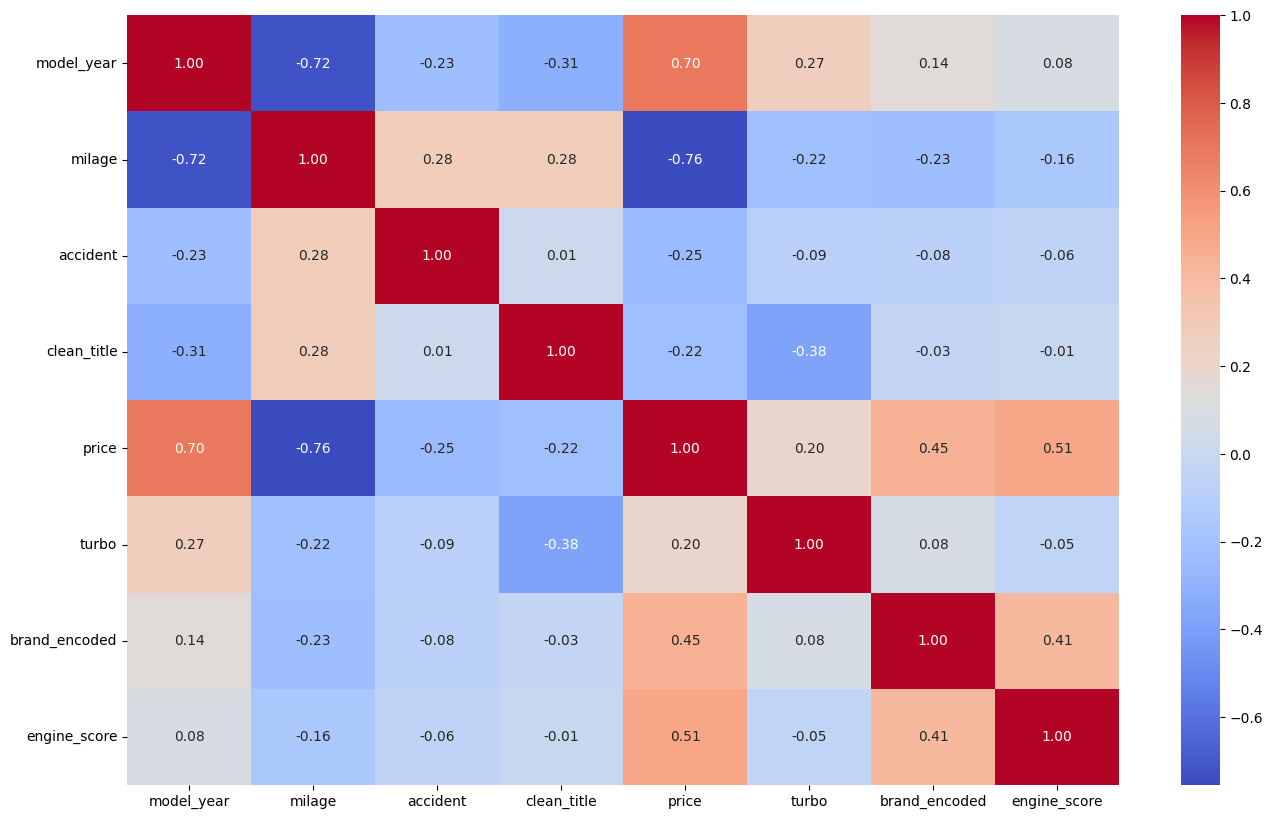

In [222]:
# Calculate the Spearman correlation
spearman_corr = dataset.corr(method='spearman')

# Filter the dataset to keep only the high correlation features
high_corr_features = spearman_corr[abs(spearman_corr['price']) >= 0.2].index
filtered_dataset = dataset[high_corr_features]

# Filter out highly correlated features
filtered_dataset = filtered_dataset.drop(['cylinders', 'horsepower', 'cubic_capacity'], axis=1)

# Filter out features with high percentage of missing values
filtered_dataset = filtered_dataset.drop(['gears'], axis=1)

# Calculate the Spearman correlation matrix
spearman_corr = filtered_dataset.corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm')

dataset = filtered_dataset.copy()

### Persist preprocessed data

In [223]:
# Save the preprocessed dataset
dataset.to_csv('./data/used_car_prices_preprocessed.csv', index=False)